<a href="https://colab.research.google.com/github/SauloHenriqueAguiar/DeepLearningRNN/blob/main/LSTMEnergia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"saulohenriaguiar","key":"f39a97212cfdbde2b816fdffcb292e24"}'}

In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download -d nicholasjhana/energy-consumption-generation-prices-and-weather

  0% 0.00/3.81M [00:00<?, ?B/s]
100% 3.81M/3.81M [00:00<00:00, 62.1MB/s]


In [7]:
!unzip energy-consumption-generation-prices-and-weather

Archive:  energy-consumption-generation-prices-and-weather.zip
  inflating: energy_dataset.csv      
  inflating: weather_features.csv    


In [8]:
import math
import pandas as pd
pd.set_option('display.max_columns', 80)
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
import warnings
warnings.filterwarnings('ignore')

In [9]:
energia = pd.read_csv('/content/energy_dataset.csv')
clima = pd.read_csv('/content/weather_features.csv')

In [10]:
energia.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation marine,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,NaN,863.0,1051.0,1899.0,0.0,7096.0,43.0,73.0,49.0,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,NaN,920.0,1009.0,1658.0,0.0,7096.0,43.0,71.0,50.0,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,NaN,1164.0,973.0,1371.0,0.0,7099.0,43.0,73.0,50.0,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,NaN,1503.0,949.0,779.0,0.0,7098.0,43.0,75.0,50.0,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,NaN,1826.0,953.0,720.0,0.0,7097.0,43.0,74.0,42.0,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


In [11]:
clima.head()

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,2015-01-01 01:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2,2015-01-01 02:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
3,2015-01-01 03:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
4,2015-01-01 04:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n


In [12]:
# O dataset de clima possui mais amostras porque contém dados de 5 cidades da Espanha.

In [13]:
# Vamos primeiro fazer um EDA com o dataset de energia.
energia.dtypes

time                                            object
generation biomass                             float64
generation fossil brown coal/lignite           float64
generation fossil coal-derived gas             float64
generation fossil gas                          float64
generation fossil hard coal                    float64
generation fossil oil                          float64
generation fossil oil shale                    float64
generation fossil peat                         float64
generation geothermal                          float64
generation hydro pumped storage aggregated     float64
generation hydro pumped storage consumption    float64
generation hydro run-of-river and poundage     float64
generation hydro water reservoir               float64
generation marine                              float64
generation nuclear                             float64
generation other                               float64
generation other renewable                     float64
generation

In [14]:
# Convertendo os dados temporais para o tipo datetime
energia['time'] = pd.to_datetime(energia['time'])

In [15]:
# Verificando dados missing
faltantes_percentual = (energia.isnull().sum() / len(energia['time'])) * 100
faltantes_percentual

time                                             0.000000
generation biomass                               0.054187
generation fossil brown coal/lignite             0.051335
generation fossil coal-derived gas               0.051335
generation fossil gas                            0.051335
generation fossil hard coal                      0.051335
generation fossil oil                            0.054187
generation fossil oil shale                      0.051335
generation fossil peat                           0.051335
generation geothermal                            0.051335
generation hydro pumped storage aggregated     100.000000
generation hydro pumped storage consumption      0.054187
generation hydro run-of-river and poundage       0.054187
generation hydro water reservoir                 0.051335
generation marine                                0.054187
generation nuclear                               0.048483
generation other                                 0.051335
generation oth

In [16]:
# Verificando quantidade de zeros
zeros_percentual = (energia[energia == 0].count() / len(energia['time'])) * 100
zeros_percentual

time                                            0.000000
generation biomass                              0.011408
generation fossil brown coal/lignite           29.993726
generation fossil coal-derived gas             99.948665
generation fossil gas                           0.002852
generation fossil hard coal                     0.008556
generation fossil oil                           0.008556
generation fossil oil shale                    99.948665
generation fossil peat                         99.948665
generation geothermal                          99.948665
generation hydro pumped storage aggregated      0.000000
generation hydro pumped storage consumption    35.954255
generation hydro run-of-river and poundage      0.008556
generation hydro water reservoir                0.008556
generation marine                              99.945813
generation nuclear                              0.008556
generation other                                0.011408
generation other renewable     

In [17]:
energia = energia.drop(['generation hydro pumped storage aggregated', 'forecast wind offshore eday ahead',
                        'generation fossil coal-derived gas', 'generation fossil oil shale', 'generation fossil peat', 
                        'generation geothermal', 'generation marine', 'generation wind offshore'], axis=1)

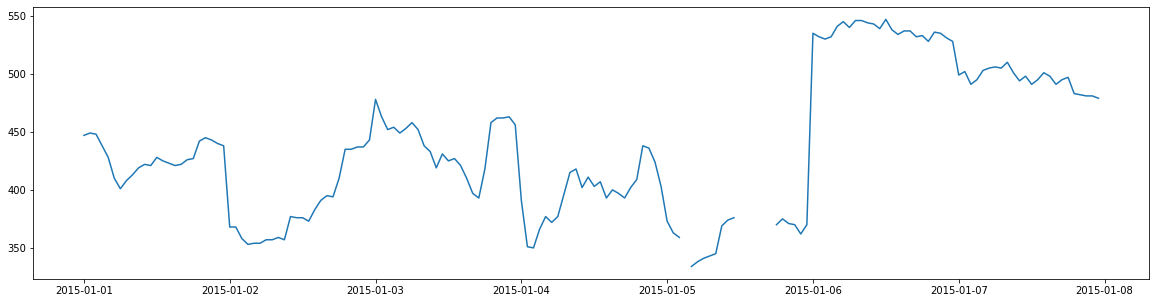

In [18]:
# Visualizando alguns dados missing no gráfico
x = energia[:24*7]['time']
y = energia[:24*7]['generation biomass']
plt.figure(figsize=(20,5))
plt.plot(x, y)

In [19]:
# Como existem poucos dados faltantes, realizar uma interpolação não deve afetar muito a performance do modelo. 
# Uma interpolação linear liga dois pontos por meio de uma reta. 
energia.interpolate(method='linear', limit_direction='forward', inplace=True)

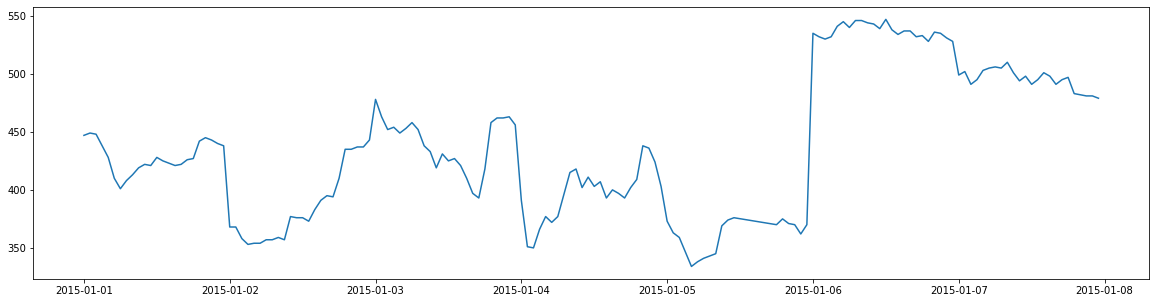

In [20]:
x = energia[:24*7]['time']
y = energia[:24*7]['generation biomass']
plt.figure(figsize=(20,5))
plt.plot(x, y)

In [21]:
# Iniciando a EDA no outro dataset:
clima.head()

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,2015-01-01 01:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2,2015-01-01 02:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
3,2015-01-01 03:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
4,2015-01-01 04:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n


In [22]:
clima.shape

(178396, 17)

In [23]:
clima.dtypes

dt_iso                  object
city_name               object
temp                   float64
temp_min               float64
temp_max               float64
pressure                 int64
humidity                 int64
wind_speed               int64
wind_deg                 int64
rain_1h                float64
rain_3h                float64
snow_3h                float64
clouds_all               int64
weather_id               int64
weather_main            object
weather_description     object
weather_icon            object
dtype: object

In [24]:
# Convertendo as colunas do type int para o type float
colunas_int = clima.select_dtypes(include=[np.int64]).columns # Seleciona os nomes das colunas do dataset que possuem o type int
for coluna in colunas_int:
    clima[coluna] = clima[coluna].values.astype(np.float64) # Muda o type para float

In [25]:
clima.dtypes

dt_iso                  object
city_name               object
temp                   float64
temp_min               float64
temp_max               float64
pressure               float64
humidity               float64
wind_speed             float64
wind_deg               float64
rain_1h                float64
rain_3h                float64
snow_3h                float64
clouds_all             float64
weather_id             float64
weather_main            object
weather_description     object
weather_icon            object
dtype: object

In [26]:
# Convertendo os dados temporais para o tipo datetime
clima['time'] = pd.to_datetime(clima['dt_iso'])
clima = clima.drop(['dt_iso'], axis=1)

In [27]:
# Verificando dados missing
faltantes_percentual = (clima.isnull().sum() / len(clima['time'])) * 100
faltantes_percentual

city_name              0.0
temp                   0.0
temp_min               0.0
temp_max               0.0
pressure               0.0
humidity               0.0
wind_speed             0.0
wind_deg               0.0
rain_1h                0.0
rain_3h                0.0
snow_3h                0.0
clouds_all             0.0
weather_id             0.0
weather_main           0.0
weather_description    0.0
weather_icon           0.0
time                   0.0
dtype: float64

In [28]:
# Analisando as variáveis do tipo objeto
clima.head()

,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon,time
0,Valencia,270.475,270.475,270.475,1001.0,77.0,1.0,62.0,0.0,0.0,0.0,0.0,800.0,clear,sky is clear,01n,2015-01-01 00:00:00+01:00
1,Valencia,270.475,270.475,270.475,1001.0,77.0,1.0,62.0,0.0,0.0,0.0,0.0,800.0,clear,sky is clear,01n,2015-01-01 01:00:00+01:00
2,Valencia,269.686,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0,0.0,800.0,clear,sky is clear,01n,2015-01-01 02:00:00+01:00
3,Valencia,269.686,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0,0.0,800.0,clear,sky is clear,01n,2015-01-01 03:00:00+01:00
4,Valencia,269.686,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0,0.0,800.0,clear,sky is clear,01n,2015-01-01 04:00:00+01:00


In [29]:
weather_description = clima['weather_description'].unique()
weather_description

array(['sky is clear', 'few clouds', 'scattered clouds', 'broken clouds',
       'overcast clouds', 'light rain', 'moderate rain',
       'heavy intensity rain', 'mist', 'heavy intensity shower rain',
       'shower rain', 'very heavy rain', 'thunderstorm with heavy rain',
       'thunderstorm with light rain', 'thunderstorm with rain',
       'proximity thunderstorm', 'thunderstorm',
       'light intensity shower rain', 'light intensity drizzle', 'fog',
       'drizzle', 'smoke', 'heavy intensity drizzle', 'haze',
       'proximity shower rain', 'light intensity drizzle rain',
       'light snow', 'rain and snow', 'light rain and snow', 'snow',
       'light thunderstorm', 'heavy snow', 'sleet', 'rain and drizzle',
       'shower sleet', 'light shower sleet', 'light shower snow',
       'proximity moderate rain', 'ragged shower rain',
       'sand dust whirls', 'proximity drizzle', 'dust', 'squalls'],
      dtype=object)

In [30]:
weather_main = clima['weather_main'].unique()
weather_main

array(['clear', 'clouds', 'rain', 'mist', 'thunderstorm', 'drizzle',
       'fog', 'smoke', 'haze', 'snow', 'dust', 'squall'], dtype=object)

In [31]:
weather_id = clima['weather_id'].unique()
weather_id

array([800., 801., 802., 803., 804., 500., 501., 502., 701., 522., 521.,
       503., 202., 200., 201., 211., 520., 300., 741., 301., 711., 302.,
       721., 310., 600., 616., 615., 601., 210., 602., 611., 311., 612.,
       620., 531., 731., 761., 771.])

In [32]:
weather_id = clima['weather_icon'].unique()
weather_id

array(['01n', '01d', '01', '02n', '02d', '02', '03', '04n', '04', '10n',
       '03n', '10', '04d', '03d', '10d', '50d', '09n', '11d', '11n',
       '09d', '50n', '13d', '13n', '13'], dtype=object)

In [33]:
print(len(weather_description))
print(len(weather_id))

43
24


In [34]:
clima = clima.drop(['weather_main', 'weather_id', 'weather_icon'], axis=1)

In [35]:
# Verificando quantas amostras há em cada cidade:
clima_agrupado = clima.groupby('city_name')
nomes_cidades = clima['city_name'].unique()
for nome in nomes_cidades:
    print(nome, clima_agrupado.get_group(nome).shape[0])
print('Dataset Energia:', energia.shape[0])

Valencia 35145
Madrid 36267
Bilbao 35951
 Barcelona 35476
Seville 35557
Dataset Energia: 35064


In [36]:
#Removendo linhas duplicadas
clima = clima.drop_duplicates(subset=['time', 'city_name'], keep='first')
clima = clima.set_index('time') # colocando time como índice do dataset

In [37]:
# Verificando novamente quantas amostras há em cada cidade:
clima_agrupado = clima.groupby('city_name')
nomes_cidades = clima['city_name'].unique()
for nome in nomes_cidades:
    print(nome, clima_agrupado.get_group(nome).shape[0])
print('Dataset Energia:', energia.shape[0])

Valencia 35064
Madrid 35064
Bilbao 35064
 Barcelona 35064
Seville 35064
Dataset Energia: 35064


In [38]:
# Aplicando label encoding na variável 'weather_description'
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
clima['weather_description'] = le.fit_transform(clima['weather_description'])

In [39]:
# Criando 5 datasets distintos (um para cada cidade):
df1, df2, df3, df4, df5 = [x for _, x in clima.groupby('city_name')] # x é o dataset agrupado da cidade e '_' é o nome da cidade
datasets_clima = [df1, df2, df3, df4, df5]

In [40]:
# Antes de agrupar todos esses datasets em um só, precisamos renomear as colunas, para melhor identificar depois. 
# Para isso, vamos usar a função .add_suffix() do Pandas. Basicamente, o que essa função faz é adicionar uma string ao final do 
# nome de cada coluna. Por exemplo, se um dataframe df possui duas colunas (col1, col2), aplicando df.add_suffix('_A'), o nome 
# das colunas ficaria: col1_A, col2_A.
# Mas para evitar que essa alteração seja feita na coluna 'time', vamos transformá-la em índice, pois essa coluna servirá como 
# referência para unir os datasets posteriormente.

energia = energia.set_index('time')

dataset_final = energia # inciando com o dataset de energia

for df in datasets_clima:
    nome_cidade = df['city_name'][0] # pegando o nome da cidade
    nome_cidade = str(nome_cidade).replace("'", '').replace(' ', '') # eliminando as aspas e espaços no nome da cidade
    df = df.add_suffix('_{}'.format(nome_cidade)) # adicionando o nome da cidade ao lado de cada coluna do dataset
    dataset_final = dataset_final.merge(df, on='time') # agrupando os datasets com base no índice 'time'
    dataset_final = dataset_final.drop('city_name_{}'.format(nome_cidade), axis=1) # excluindo a coluna city_name

In [41]:
dataset_final.head()

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,forecast solar day ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual,temp_Barcelona,temp_min_Barcelona,temp_max_Barcelona,pressure_Barcelona,humidity_Barcelona,wind_speed_Barcelona,wind_deg_Barcelona,rain_1h_Barcelona,rain_3h_Barcelona,snow_3h_Barcelona,clouds_all_Barcelona,weather_description_Barcelona,temp_Bilbao,temp_min_Bilbao,temp_max_Bilbao,pressure_Bilbao,humidity_Bilbao,wind_speed_Bilbao,wind_deg_Bilbao,rain_1h_Bilbao,rain_3h_Bilbao,snow_3h_Bilbao,clouds_all_Bilbao,weather_description_Bilbao,temp_Madrid,temp_min_Madrid,temp_max_Madrid,pressure_Madrid,humidity_Madrid,wind_speed_Madrid,wind_deg_Madrid,rain_1h_Madrid,rain_3h_Madrid,snow_3h_Madrid,clouds_all_Madrid,weather_description_Madrid,temp_Seville,temp_min_Seville,temp_max_Seville,pressure_Seville,humidity_Seville,wind_speed_Seville,wind_deg_Seville,rain_1h_Seville,rain_3h_Seville,snow_3h_Seville,clouds_all_Seville,weather_description_Seville,temp_Valencia,temp_min_Valencia,temp_max_Valencia,pressure_Valencia,humidity_Valencia,wind_speed_Valencia,wind_deg_Valencia,rain_1h_Valencia,rain_3h_Valencia,snow_3h_Valencia,clouds_all_Valencia,weather_description_Valencia
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00+01:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,43.0,73.0,49.0,196.0,6378.0,17.0,6436.0,26118.0,25385.0,50.10,65.41,281.625,281.625,281.625,1035.0,100.0,7.0,58.0,0.0,0.0,0.0,0.0,31,269.657312,269.657312,269.657312,1036.0,97.0,0.0,226.0,0.0,0.0,0.0,0.0,31,267.325,267.325,267.325,971.0,63.0,1.0,309.0,0.0,0.0,0.0,0.0,31,273.375,273.375,273.375,1039.0,75.0,1.0,21.0,0.0,0.0,0.0,0.0,31,270.475,270.475,270.475,1001.0,77.0,1.0,62.0,0.0,0.0,0.0,0.0,31
2015-01-01 01:00:00+01:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,43.0,71.0,50.0,195.0,5890.0,16.0,5856.0,24934.0,24382.0,48.10,64.92,281.625,281.625,281.625,1035.0,100.0,7.0,58.0,0.0,0.0,0.0,0.0,31,269.763500,269.763500,269.763500,1035.0,97.0,0.0,229.0,0.0,0.0,0.0,0.0,31,267.325,267.325,267.325,971.0,63.0,1.0,309.0,0.0,0.0,0.0,0.0,31,273.375,273.375,273.375,1039.0,75.0,1.0,21.0,0.0,0.0,0.0,0.0,31,270.475,270.475,270.475,1001.0,77.0,1.0,62.0,0.0,0.0,0.0,0.0,31
2015-01-01 02:00:00+01:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,43.0,73.0,50.0,196.0,5461.0,8.0,5454.0,23515.0,22734.0,47.33,64.48,281.286,281.286,281.286,1036.0,100.0,7.0,48.0,0.0,0.0,0.0,0.0,31,269.251688,269.251688,269.251688,1036.0,97.0,1.0,224.0,0.0,0.0,0.0,0.0,31,266.186,266.186,266.186,971.0,64.0,1.0,273.0,0.0,0.0,0.0,0.0,31,274.086,274.086,274.086,1039.0,71.0,3.0,27.0,0.0,0.0,0.0,0.0,31,269.686,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0,0.0,31
2015-01-01 03:00:00+01:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,43.0,75.0,50.0,191.0,5238.0,2.0,5151.0,22642.0,21286.0,42.27,59.32,281.286,281.286,281.286,1036.0,100.0,7.0,48.0,0.0,0.0,0.0,0.0,31,269.203344,269.203344,269.203344,1035.0,97.0,1.0,225.0,0.0,0.0,0.0,0.0,31,266.186,266.186,266.186,971.0,64.0,1.0,273.0,0.0,0.0,0.0,0.0,31,274.086,274.086,274.086,1039.0,71.0,3.0,27.0,0.0,0.0,0.0,0.0,31,269.686,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0,0.0,31
2015-01-01 04:00:00+01:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,43.0,74.0,42.0,189.0,4935.0,9.0,4861.0,21785.0,20264.0,38.41,56.04,281.286,281.286,281.286,1036.0,100.0,7.0,48.0,0.0,0.0,0.0,0.0,31,269.485500,269.485500,269.485500,1035.0,97.0,1.0,221.0,0.0,0.0,0.0,0.0,31,266.186,266.186,266.186,971.0,64.0,1.0,273.0,0.0,0.0,0.0,0.0,31,274.086,274.086,274.086,1039.0,71.0,3.0,27.0,0.0,0.0,0.0,0.0,3

In [42]:
energia.shape

(35064, 20)

In [43]:
clima.shape

(175320, 13)

In [44]:
dataset_final.shape
# O dataset de energia possui 20 colunas e o dataset de clima possui 13 - 1. Então 12x5 + 20 = 80. 

(35064, 80)

In [45]:
# Criando uma função para calcular a performance das previsões:
from sklearn.metrics import mean_squared_error
from math import sqrt

def rmse(valores_previstos, valores_reais):
    rmse = sqrt(mean_squared_error(valores_previstos, valores_reais))
    print('O RMSE calculado é:', rmse)

In [46]:
# Verificando a performance do modelo oficial da TSO:
rmse(dataset_final['price day ahead'], dataset_final['price actual'])

O RMSE calculado é: 13.249856853754762


In [47]:
# Eliminando a coluna de previsão de preço feita pela TSO:
dataset = dataset_final.drop('price day ahead', axis=1)

In [48]:
dataset

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,forecast solar day ahead,forecast wind onshore day ahead,total load forecast,total load actual,price actual,temp_Barcelona,temp_min_Barcelona,temp_max_Barcelona,pressure_Barcelona,humidity_Barcelona,wind_speed_Barcelona,wind_deg_Barcelona,rain_1h_Barcelona,rain_3h_Barcelona,snow_3h_Barcelona,clouds_all_Barcelona,weather_description_Barcelona,temp_Bilbao,temp_min_Bilbao,temp_max_Bilbao,pressure_Bilbao,humidity_Bilbao,wind_speed_Bilbao,wind_deg_Bilbao,rain_1h_Bilbao,rain_3h_Bilbao,snow_3h_Bilbao,clouds_all_Bilbao,weather_description_Bilbao,temp_Madrid,temp_min_Madrid,temp_max_Madrid,pressure_Madrid,humidity_Madrid,wind_speed_Madrid,wind_deg_Madrid,rain_1h_Madrid,rain_3h_Madrid,snow_3h_Madrid,clouds_all_Madrid,weather_description_Madrid,temp_Seville,temp_min_Seville,temp_max_Seville,pressure_Seville,humidity_Seville,wind_speed_Seville,wind_deg_Seville,rain_1h_Seville,rain_3h_Seville,snow_3h_Seville,clouds_all_Seville,weather_description_Seville,temp_Valencia,temp_min_Valencia,temp_max_Valencia,pressure_Valencia,humidity_Valencia,wind_speed_Valencia,wind_deg_Valencia,rain_1h_Valencia,rain_3h_Valencia,snow_3h_Valencia,clouds_all_Valencia,weather_description_Valencia
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00+01:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,43.0,73.0,49.0,196.0,6378.0,17.0,6436.0,26118.0,25385.0,65.41,281.625,281.625,281.625,1035.0,100.0,7.0,58.0,0.0,0.0,0.0,0.0,31,269.657312,269.657312,269.657312,1036.0,97.0,0.0,226.0,0.0,0.0,0.0,0.0,31,267.325,267.325,267.325,971.0,63.0,1.0,309.0,0.0,0.0,0.0,0.0,31,273.375,273.375,273.375,1039.0,75.0,1.0,21.0,0.0,0.0,0.0,0.0,31,270.475,270.475,270.475,1001.0,77.0,1.0,62.0,0.0,0.0,0.0,0.0,31
2015-01-01 01:00:00+01:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,43.0,71.0,50.0,195.0,5890.0,16.0,5856.0,24934.0,24382.0,64.92,281.625,281.625,281.625,1035.0,100.0,7.0,58.0,0.0,0.0,0.0,0.0,31,269.763500,269.763500,269.763500,1035.0,97.0,0.0,229.0,0.0,0.0,0.0,0.0,31,267.325,267.325,267.325,971.0,63.0,1.0,309.0,0.0,0.0,0.0,0.0,31,273.375,273.375,273.375,1039.0,75.0,1.0,21.0,0.0,0.0,0.0,0.0,31,270.475,270.475,270.475,1001.0,77.0,1.0,62.0,0.0,0.0,0.0,0.0,31
2015-01-01 02:00:00+01:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,43.0,73.0,50.0,196.0,5461.0,8.0,5454.0,23515.0,22734.0,64.48,281.286,281.286,281.286,1036.0,100.0,7.0,48.0,0.0,0.0,0.0,0.0,31,269.251688,269.251688,269.251688,1036.0,97.0,1.0,224.0,0.0,0.0,0.0,0.0,31,266.186,266.186,266.186,971.0,64.0,1.0,273.0,0.0,0.0,0.0,0.0,31,274.086,274.086,274.086,1039.0,71.0,3.0,27.0,0.0,0.0,0.0,0.0,31,269.686,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0,0.0,31
2015-01-01 03:00:00+01:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,43.0,75.0,50.0,191.0,5238.0,2.0,5151.0,22642.0,21286.0,59.32,281.286,281.286,281.286,1036.0,100.0,7.0,48.0,0.0,0.0,0.0,0.0,31,269.203344,269.203344,269.203344,1035.0,97.0,1.0,225.0,0.0,0.0,0.0,0.0,31,266.186,266.186,266.186,971.0,64.0,1.0,273.0,0.0,0.0,0.0,0.0,31,274.086,274.086,274.086,1039.0,71.0,3.0,27.0,0.0,0.0,0.0,0.0,31,269.686,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0,0.0,31
2015-01-01 04:00:00+01:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,43.0,74.0,42.0,189.0,4935.0,9.0,4861.0,21785.0,20264.0,56.04,281.286,281.286,281.286,1036.0,100.0,7.0,48.0,0.0,0.0,0.0,0.0,31,269.485500,269.485500,269.485500,1035.0,97.0,1.0,221.0,0.0,0.0,0.0,0.0,31,266.186,266.186,266.186,971.0,64.0,1.0,273.0,0.0,0.0,0.0,0.0,31,274.086,274.086,274.086,1039.0,71.0,3.0,27.0,0.0,0.0,0.0,0.0,31,269.686,269.686,269.686,1002.0,78.0,0.0,23.0,

In [49]:
from sklearn.preprocessing import MinMaxScaler
# Normalizando os dados
scaler = MinMaxScaler(feature_range = (0, 1))
dataset_norm = scaler.fit_transform(dataset.values) # o resultado dessa operação será um array de vetores
# Transformando esse resultado em um dataframe Pandas novamente:
dataset = pd.DataFrame(dataset_norm, index=dataset.index, columns=dataset.columns)

In [50]:
dataset.head()

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,forecast solar day ahead,forecast wind onshore day ahead,total load forecast,total load actual,price actual,temp_Barcelona,temp_min_Barcelona,temp_max_Barcelona,pressure_Barcelona,humidity_Barcelona,wind_speed_Barcelona,wind_deg_Barcelona,rain_1h_Barcelona,rain_3h_Barcelona,snow_3h_Barcelona,clouds_all_Barcelona,weather_description_Barcelona,temp_Bilbao,temp_min_Bilbao,temp_max_Bilbao,pressure_Bilbao,humidity_Bilbao,wind_speed_Bilbao,wind_deg_Bilbao,rain_1h_Bilbao,rain_3h_Bilbao,snow_3h_Bilbao,clouds_all_Bilbao,weather_description_Bilbao,temp_Madrid,temp_min_Madrid,temp_max_Madrid,pressure_Madrid,humidity_Madrid,wind_speed_Madrid,wind_deg_Madrid,rain_1h_Madrid,rain_3h_Madrid,snow_3h_Madrid,clouds_all_Madrid,weather_description_Madrid,temp_Seville,temp_min_Seville,temp_max_Seville,pressure_Seville,humidity_Seville,wind_speed_Seville,wind_deg_Seville,rain_1h_Seville,rain_3h_Seville,snow_3h_Seville,clouds_all_Seville,weather_description_Seville,temp_Valencia,temp_min_Valencia,temp_max_Valencia,pressure_Valencia,humidity_Valencia,wind_speed_Valencia,wind_deg_Valencia,rain_1h_Valencia,rain_3h_Valencia,snow_3h_Valencia,clouds_all_Valencia,weather_description_Valencia
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00+01:00,0.755068,0.329329,0.241789,0.576744,0.360802,0.190803,0.5255,0.195210,0.997049,0.40566,0.613445,0.008460,0.549020,0.365795,0.002913,0.360554,0.344127,0.319666,0.521820,0.413238,0.431641,0.364860,0.001026,1.0,0.466667,0.161111,0.0,0.0,0.0,0.0,0.775,0.061537,0.114999,0.013659,0.925926,0.966292,0.000000,0.627778,0.0,0.0,0.0,0.0,0.794872,0.064901,0.066496,0.060996,0.382609,0.63,0.055556,0.858333,0.0,0.0,0.0,0.0,0.794872,0.052189,0.091848,0.026728,0.509615,0.731183,0.066667,0.058333,0.0,0.0,0.0,0.0,0.794872,0.038856,0.038856,0.035755,0.271186,0.75000,0.007519,0.172222,0.0,0.0,0.0,0.0,0.775
2015-01-01 01:00:00+01:00,0.758446,0.328328,0.259359,0.568848,0.351893,0.203405,0.5045,0.170436,0.997049,0.40566,0.596639,0.008633,0.546218,0.337807,0.002742,0.326819,0.293279,0.276008,0.517261,0.413238,0.431641,0.364860,0.001026,1.0,0.466667,0.161111,0.0,0.0,0.0,0.0,0.775,0.063865,0.117217,0.015795,0.913580,0.966292,0.000000,0.636111,0.0,0.0,0.0,0.0,0.794872,0.064901,0.066496,0.060996,0.382609,0.63,0.055556,0.858333,0.0,0.0,0.0,0.0,0.794872,0.052189,0.091848,0.026728,0.509615,0.731183,0.066667,0.058333,0.0,0.0,0.0,0.0,0.794872,0.038856,0.038856,0.035755,0.271186,0.75000,0.007519,0.172222,0.0,0.0,0.0,0.0,0.775
2015-01-01 02:00:00+01:00,0.756757,0.323323,0.242438,0.548032,0.349666,0.257351,0.4865,0.140933,0.997471,0.40566,0.613445,0.008633,0.549020,0.313203,0.001371,0.303437,0.232338,0.204274,0.513166,0.406012,0.424093,0.358479,0.001027,1.0,0.466667,0.133333,0.0,0.0,0.0,0.0,0.775,0.052645,0.106529,0.005503,0.925926,0.966292,0.066667,0.622222,0.0,0.0,0.0,0.0,0.794872,0.041750,0.042776,0.039237,0.382609,0.64,0.055556,0.758333,0.0,0.0,0.0,0.0,0.794872,0.068148,0.107304,0.041213,0.509615,0.688172,0.200000,0.075000,0.0,0.0,0.0,0.0,0.794872,0.020212,0.020212,0.018599,0.279661,0.76087,0.000000,0.063889,0.0,0.0,0.0,0.0,0.775
2015-01-01 03:00:00+01:00,0.739865,0.254254,0.215334,0.494198,0.356347,0.332302,0.4745,0.080078,0.997330,0.40566,0.630252,0.008633,0.535014,0.300413,0.000343,0.285814,0.194846,0.141247,0.465153,0.406012,0.424093,0.358479,0.001027,1.0,0.466667,0.133333,0.0,0.0,0.0,0.0,0.775,0.051586,0.105520,0.004531,0.913580,0.966292,0.066667,0.625000,0.0,0.0,0.0,0.0,0.794872,0.041750,0.042776,0.039237,0.382609,0.64,0.055556,0.758333,0.0,0.0,0.0,0.0,0.794872,0.068148,0.107304,0.041213,0.509615,0.688172,0.200000,0.075000,0.0

In [51]:
# Separando os dados em treino e teste
tamanho_treino = int(len(dataset) * 0.7)
treino, teste = dataset[0:tamanho_treino], dataset[tamanho_treino:len(dataset)]
treino = treino.reset_index(drop=True)
teste = teste.reset_index(drop=True) # Como depois iremos usar o comando .loc, precisaremos que os índices estejam iniciando em zero em ambos os dataframes

In [52]:
# Criando uma função para as janelas temporais. A saída será dois arrays, o primeiro contendo várias janelas do dataset, e o
# segundo contendo valores a serem previstos
def gera_dataset(dataset, tamanho_janela = 1):
    dataA, dataB = [], []
    for i in range(len(dataset)-tamanho_janela): # lembre-se que os datasets têm índices começando em zero
        a = dataset[i:(i+tamanho_janela)].to_numpy()
        dataA.append(a)
        dataB.append(dataset['price actual'].loc[[i+tamanho_janela]].to_numpy()) 
    return np.asarray(dataA, dtype=np.float32), np.asarray(dataB, dtype=np.float32)

In [53]:
# Aplicando a função nos datasets de treino e teste que já criamos:
tamanho_janela=10
x_treino, y_treino = gera_dataset(treino, tamanho_janela=tamanho_janela)
x_teste, y_teste = gera_dataset(teste, tamanho_janela=tamanho_janela)

In [54]:
x_treino.shape

(24534, 10, 79)

In [55]:
x_teste.shape

(10510, 10, 79)

In [56]:
# Utilizando LSTM:
from keras.layers import LSTM

In [57]:
# Criando o modelo LSTM
modelo = Sequential()
modelo.add(LSTM(20, input_shape = (x_treino.shape[1], x_treino.shape[2]))) 

# Em input_shape nós precisamos informar apenas 2 valores: n_timesteps e n_features da variável X (entrada).

modelo.add(Dense(1)) # Saída da LSTM
modelo.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [58]:
modelo.fit(x_treino, y_treino, epochs = 200, batch_size = 500, verbose = 2)

Epoch 1/200
50/50 - 5s - loss: 0.0304 - 5s/epoch - 100ms/step
Epoch 2/200
50/50 - 0s - loss: 0.0128 - 260ms/epoch - 5ms/step
Epoch 3/200
50/50 - 0s - loss: 0.0101 - 278ms/epoch - 6ms/step
Epoch 4/200
50/50 - 0s - loss: 0.0078 - 267ms/epoch - 5ms/step
Epoch 5/200
50/50 - 0s - loss: 0.0056 - 276ms/epoch - 6ms/step
Epoch 6/200
50/50 - 0s - loss: 0.0044 - 272ms/epoch - 5ms/step
Epoch 7/200
50/50 - 0s - loss: 0.0035 - 260ms/epoch - 5ms/step
Epoch 8/200
50/50 - 0s - loss: 0.0030 - 253ms/epoch - 5ms/step
Epoch 9/200
50/50 - 0s - loss: 0.0026 - 265ms/epoch - 5ms/step
Epoch 10/200
50/50 - 0s - loss: 0.0024 - 267ms/epoch - 5ms/step
Epoch 11/200
50/50 - 0s - loss: 0.0022 - 264ms/epoch - 5ms/step
Epoch 12/200
50/50 - 0s - loss: 0.0021 - 263ms/epoch - 5ms/step
Epoch 13/200
50/50 - 0s - loss: 0.0019 - 267ms/epoch - 5ms/step
Epoch 14/200
50/50 - 0s - loss: 0.0019 - 274ms/epoch - 5ms/step
Epoch 15/200
50/50 - 0s - loss: 0.0018 - 260ms/epoch - 5ms/step
Epoch 16/200
50/50 - 0s - loss: 0.0016 - 259ms/epo

In [59]:
# Fazendo as previsões e avaliando a performance
previsoes_treino = modelo.predict(x_treino)
# A previsão tem como resultado um array de dimensões (n_amostras, 1), então se tentarmos executar o inverso da normalização
# diretamente com esses dados, teremos uma mensagem de erro, afinal a normalização foi aplicada em um dataset de dimensões:
# (n_amostras, 79), ou seja, a função scaler.inverse_transform não saberá o que fazer para gerar o inverso das outras 78 colunas.
# Portanto iremos primeiro gerar uma matriz com a mesma quantidade de colunas de x_treino (preenchida com zeros), depois iremos
# colocar o array de previsões em uma coluna dessa matriz (no lugar onde estava o price_actual), então poderemos aplicar a função
# scaler.inverse_transform e depois coletar somente a coluna que nos interessa.
# Obs: para descobrir qual o índice da coluna que possui a feature "price actual", basta utilizar o código: 
# treino.columns.get_loc("price actual")

# Previsões com os dados de treino:
previsoes_treino_dataset_size = np.zeros(shape=(len(previsoes_treino), x_treino.shape[2]))
previsoes_treino_dataset_size[:,18] = previsoes_treino[:,0]
previsoes_treino = scaler.inverse_transform(previsoes_treino_dataset_size)[:,18]

# Previsões com os dados de teste:
previsoes_teste = modelo.predict(x_teste)
previsoes_teste_dataset_size = np.zeros(shape=(len(previsoes_teste), x_teste.shape[2]))
previsoes_teste_dataset_size[:,18] = previsoes_teste[:,0]
previsoes_teste = scaler.inverse_transform(previsoes_teste_dataset_size)[:,18]

# Invertendo a normalização das variáveis target:
y_treino_dataset_size = np.zeros(shape=(len(y_treino), x_treino.shape[2]))
y_treino_dataset_size[:,18] = y_treino[:,0]
y_treino = scaler.inverse_transform(y_treino_dataset_size)[:,18]

y_teste_dataset_size = np.zeros(shape=(len(y_teste), x_teste.shape[2]))
y_teste_dataset_size[:,18] = y_teste[:,0]
y_teste = scaler.inverse_transform(y_teste_dataset_size)[:,18]

# Calculando o RMSE:
score_treino = math.sqrt(mean_squared_error(y_treino, previsoes_treino))
print('Score em Treino: %.2f RMSE' % (score_treino))  
score_teste = math.sqrt(mean_squared_error(y_teste, previsoes_teste))
print('Score em Teste: %.2f RMSE' % (score_teste))

Score em Treino: 2.89 RMSE
Score em Teste: 3.25 RMSE


In [63]:
# Criando o modelo LSTM
modelo = Sequential()
modelo.add(LSTM(20, batch_input_shape = (2, x_treino.shape[1], x_treino.shape[2]), stateful = True)) 

# Em input_shape nós precisamos informar apenas 2 valores: n_timesteps e n_features da variável X (entrada).

modelo.add(Dense(1)) # Saída da LSTM
modelo.compile(loss = 'mean_squared_error', optimizer = 'adam')
modelo.fit(x_treino, y_treino, epochs = 20, batch_size = 2, verbose = 2)

Epoch 1/20
12267/12267 - 40s - loss: 333.4522 - 40s/epoch - 3ms/step
Epoch 2/20
12267/12267 - 39s - loss: 21.9161 - 39s/epoch - 3ms/step
Epoch 3/20
12267/12267 - 39s - loss: 12.8170 - 39s/epoch - 3ms/step
Epoch 4/20
12267/12267 - 39s - loss: 10.4145 - 39s/epoch - 3ms/step
Epoch 5/20
12267/12267 - 39s - loss: 9.5973 - 39s/epoch - 3ms/step
Epoch 6/20
12267/12267 - 39s - loss: 9.1919 - 39s/epoch - 3ms/step
Epoch 7/20
12267/12267 - 39s - loss: 8.9920 - 39s/epoch - 3ms/step
Epoch 8/20
12267/12267 - 39s - loss: 8.8207 - 39s/epoch - 3ms/step
Epoch 9/20
12267/12267 - 39s - loss: 8.6546 - 39s/epoch - 3ms/step
Epoch 10/20
12267/12267 - 39s - loss: 8.5392 - 39s/epoch - 3ms/step
Epoch 11/20
12267/12267 - 39s - loss: 8.3968 - 39s/epoch - 3ms/step
Epoch 12/20
12267/12267 - 39s - loss: 8.2334 - 39s/epoch - 3ms/step
Epoch 13/20
12267/12267 - 39s - loss: 8.0157 - 39s/epoch - 3ms/step
Epoch 14/20
12267/12267 - 39s - loss: 7.7853 - 39s/epoch - 3ms/step
Epoch 15/20
12267/12267 - 39s - loss: 7.6328 - 39s/e

In [73]:
from sklearn.metrics import mean_squared_error

# Previsões
previsoes_treino = modelo.predict(x_treino, batch_size=2)
previsoes_teste = modelo.predict(x_teste, batch_size=2)



# Calcula o RMSE
score_treino = math.sqrt(mean_squared_error(y_treino, previsoes_treino))
print('Score em Treino: %.2f RMSE' % (score_treino))  
score_teste = math.sqrt(mean_squared_error(y_teste, previsoes_teste))
print('Score em Teste: %.2f RMSE' % (score_teste))

Score em Treino: 2.57 RMSE
Score em Teste: 2.96 RMSE
